In [137]:
import pandas as pd
import numpy as np

In [38]:
vo2max_data = pd.read_csv("data/vo2max_dataset.csv")

In [39]:
vo2max_data

,pid,TRNSCRPT;ADRNL;ENSRNOG00000000008,TRNSCRPT;SKM-VL;ENSRNOG00000000012,TRNSCRPT;ADRNL;ENSRNOG00000000012,TRNSCRPT;BLOOD;ENSRNOG00000000033,TRNSCRPT;SPLEEN;ENSRNOG00000000034,TRNSCRPT;COLON;ENSRNOG00000000034,TRNSCRPT;OVARY;ENSRNOG00000000036,TRNSCRPT;ADRNL;ENSRNOG00000000036,TRNSCRPT;COLON;ENSRNOG00000000036,...,TRNSCRPT;WAT-SC;ENSRNOG00000062276,ATAC;LIVER;chr15:93634588-93635092,TRNSCRPT;HEART;ENSRNOG00000062298,TRNSCRPT;HIPPOC;ENSRNOG00000062298,TRNSCRPT;KIDNEY;ENSRNOG00000062298,TRNSCRPT;BLOOD;ENSRNOG00000062298,TRNSCRPT;CORTEX;ENSRNOG00000062298,TRNSCRPT;ADRNL;ENSRNOG00000062306,vo2max,group
0,10502300,-0.59007,3.34911,0.02768,10.61489,4.91776,5.96585,NaN,7.85651,4.42718,...,4.46024,5.08,7.80660,7.98805,8.22936,9.72547,7.95315,3.70898,NaN,2w
1,10046461,-0.76078,2.56057,-1.56168,11.42502,4.93014,6.20550,8.44338,7.55534,5.41303,...,4.73555,5.08,7.83103,7.83183,8.53105,10.14496,7.95287,3.39867,84.06,8w
2,10026355,-0.43588,2.41595,-1.27477,10.35532,4.83576,5.99471,NaN,7.33771,5.20841,...,3.76618,5.08,7.90798,8.02354,8.14800,9.65669,7.93508,3.80897,52.64,control
3,10139044,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.37,4w
4,10417702,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1w
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,10381414,-1.50401,3.20343,-0.47941,10.49174,4.87997,5.77650,9.31307,7.46678,4.85469,...,4.68754,5.00,7.89467,8.07592,8.47443,9.49881,7.92551,3.18561,71.92,4w
67,10950486,-1.67123,3.00107,-0.24669,10.93355,4.85299,6.25547,8.35527,7.59105,4.56407,...,4.90373,4.99,7.88587,7.85276,8.54627,9.72736,7.72874,3.07414,NaN,1w
68,10046380,1.28560,2.85838,3.03771,10.59316,4.96145,6.04798,8.62297,6.92961,4.90772,...,4.90740,5.05,7.91631,7.86505,8.38762,9.55499,7.89062,3.50661,61.43,control
69,10106383,-1.40085,3.17792,0.06307,10.64148,4.88907,6.06547,NaN,7.14024,5.05786,...,3.40672,5.26,7.82569,7.88266,8.38536,10.26058,7.80084,4.02136,67.30,4w


## ML Model
Using ensembl method of gradient boosting trees.

In [134]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [150]:
X = vo2max_data.iloc[:,1:len(vo2max_data.columns)-2]
y = vo2max_data.iloc[:,len(vo2max_data.columns)-2]
stratify = vo2max_data["group"]

In [151]:
# dropping vo2 max instances with nas
y = y.dropna(axis=0)
y.reset_index(drop=True, inplace=True)

In [152]:
# mean imputation of data
X_imputed = X.fillna(X.mean())

In [153]:
indices_to_keep = y.index

X_imputed = X_imputed.iloc[indices_to_keep, :]
X_imputed.reset_index(drop=True, inplace=True)

In [154]:
stratify = stratify.iloc[indices_to_keep]
stratify.reset_index(drop=True, inplace=True)

In [155]:
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.20, random_state=42, stratify=stratify)

In [156]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(36, 22680)
(36,)
(10, 22680)
(10,)


In [157]:
gbr = GradientBoostingRegressor()

In [158]:
gbr.fit(X_train, y_train)

GradientBoostingRegressor()

In [159]:
gbr.score(X_test, y_test)

-0.34533309859532024

In [160]:
# Predict on the test set
y_pred = gbr.predict(X_test)
y_pred

array([75.686385  , 79.13185493, 75.686385  , 74.06474615, 73.72831616,
       75.47099656, 75.686385  , 75.686385  , 65.23526511, 74.8621911 ])

In [161]:
import matplotlib.pyplot as plt

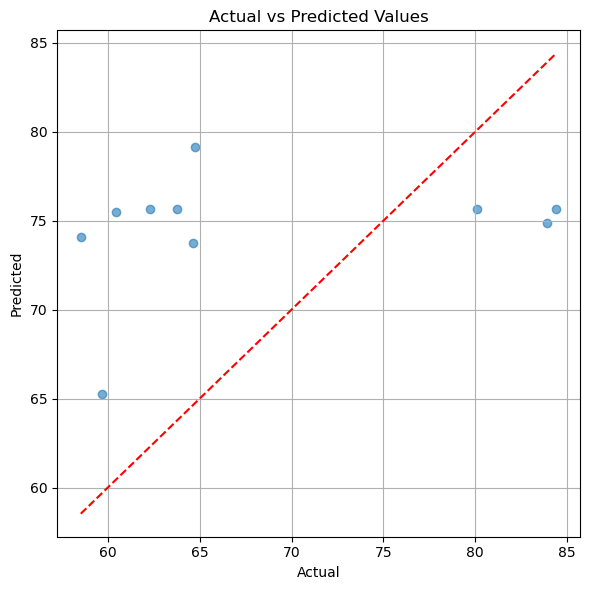

In [162]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted Values")
plt.grid(True)
plt.tight_layout()
plt.show()

## PLS feature selection

In [163]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler

In [164]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Fit PLS
pls = PLSRegression(n_components=2)
pls.fit(X_scaled, y)

PLSRegression()

In [166]:
# Get absolute sum of weights across components
feature_importance = np.abs(pls.x_weights_).sum(axis=1)

# Create a dataframe for easier viewing
feature_names = X_imputed.columns if hasattr(X_imputed, "columns") else [f"X{i}" for i in range(X_imputed.shape[1])]
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)

In [190]:
top_features_
top_features_5 = importance_df.head(5)["Feature"].tolist()
top_features_10 = importance_df.head(10)["Feature"].tolist()
top_features_100 = importance_df.head(100)["Feature"].tolist()
top_features_1000 = importance_df.head(1000)["Feature"].tolist()

# Now you can subset your data
X_top_10 = X_imputed[top_features_10]
X_top_10_train, X_top_10_test, y_top_10_train, y_top_10_test = train_test_split(X_top_10, y, test_size=0.20, random_state=42, stratify=stratify)

In [180]:
X_top_10_test.columns

Index(['METHYL;BAT;chr1-449942_cluster4', 'METHYL;BAT;chr19-38808_cluster4',
       'METHYL;WAT-SC;chr3-220638_cluster2',
       'TRNSCRPT;SKM-GN;ENSRNOG00000048270',
       'TRNSCRPT;BLOOD;ENSRNOG00000007370',
       'TRNSCRPT;LIVER;ENSRNOG00000048402',
       'ATAC;LIVER;chr16:54500934-54501155',
       'TRNSCRPT;ADRNL;ENSRNOG00000030580',
       'METHYL;WAT-SC;chr6-193036_cluster2',
       'ATAC;LIVER;chr14:100039365-100040215'],
      dtype='object')

In [178]:
X_top_10_train.columns

Index(['METHYL;BAT;chr1-449942_cluster4', 'METHYL;BAT;chr19-38808_cluster4',
       'METHYL;WAT-SC;chr3-220638_cluster2',
       'TRNSCRPT;SKM-GN;ENSRNOG00000048270',
       'TRNSCRPT;BLOOD;ENSRNOG00000007370',
       'TRNSCRPT;LIVER;ENSRNOG00000048402',
       'ATAC;LIVER;chr16:54500934-54501155',
       'TRNSCRPT;ADRNL;ENSRNOG00000030580',
       'METHYL;WAT-SC;chr6-193036_cluster2',
       'ATAC;LIVER;chr14:100039365-100040215'],
      dtype='object')

In [181]:
gbr10 = GradientBoostingRegressor()
gbr10.fit(X_top_10_train, y_top_10_train)
gbr10.score(X_top_10_test, y_top_10_test)

0.3050468733598164

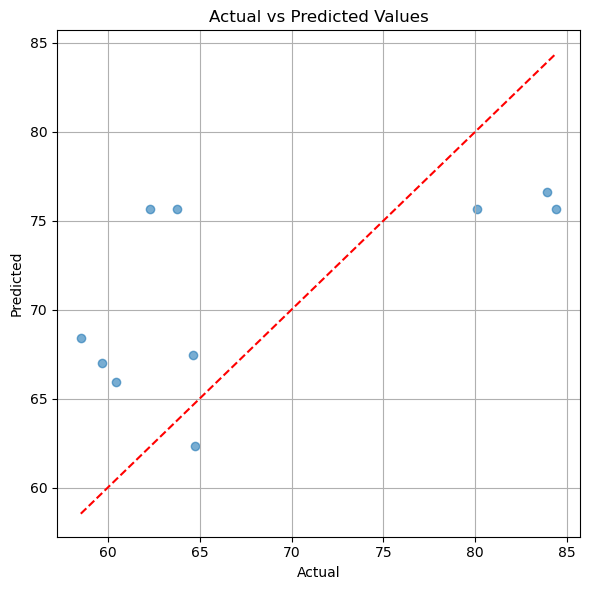

In [184]:
# Predict on the test set
y_pred_top_10 = gbr10.predict(X_top_10_test)

plt.figure(figsize=(6, 6))
plt.scatter(y_top_10_test, y_pred_top_10, alpha=0.6)
plt.plot([y_top_10_test.min(), y_top_10_test.max()], [y_top_10_test.min(), y_top_10_test.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted Values")
plt.grid(True)
plt.tight_layout()
plt.show()

In [185]:
# Now you can subset your data
X_top_100 = X_imputed[top_features_100]
X_top_100_train, X_top_100_test, y_top_100_train, y_top_100_test = train_test_split(X_top_100, y, test_size=0.20, random_state=42, stratify=stratify)

In [186]:
gbr100 = GradientBoostingRegressor()
gbr100.fit(X_top_100_train, y_top_100_train)
gbr100.score(X_top_100_test, y_top_100_test)

-0.3802905959175027

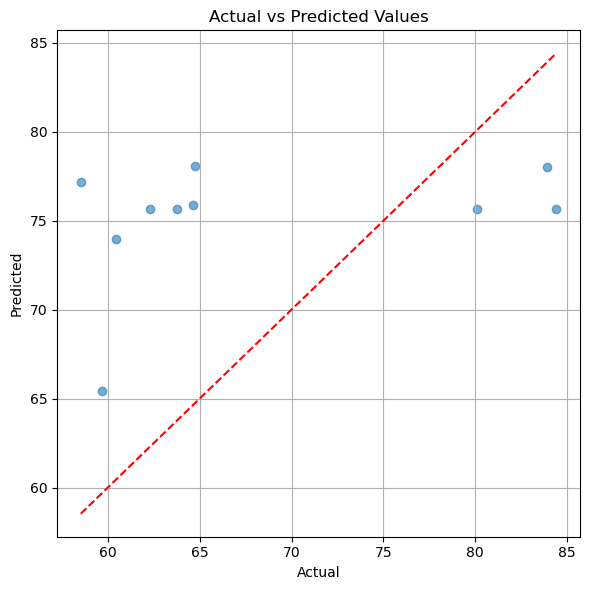

In [189]:
# Predict on the test set
y_pred_top_100 = gbr100.predict(X_top_100_test)

plt.figure(figsize=(6, 6))
plt.scatter(y_top_100_test, y_pred_top_100, alpha=0.6)
plt.plot([y_top_100_test.min(), y_top_100_test.max()], [y_top_100_test.min(), y_top_100_test.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted Values")
plt.grid(True)
plt.tight_layout()
plt.show()

In [187]:
# Now you can subset your data
X_top_1000 = X_imputed[top_features_1000]
X_top_1000_train, X_top_1000_test, y_top_1000_train, y_top_1000_test = train_test_split(X_top_1000, y, test_size=0.20, random_state=42, stratify=stratify)

In [188]:
gbr1000 = GradientBoostingRegressor()
gbr1000.fit(X_top_1000_train, y_top_1000_train)
gbr1000.score(X_top_1000_test, y_top_1000_test)

-0.2119315749907822

In [191]:
# Now you can subset your data
X_top_5 = X_imputed[top_features_5]
X_top_5_train, X_top_5_test, y_top_5_train, y_top_5_test = train_test_split(X_top_5, y, test_size=0.20, random_state=42, stratify=stratify)

In [192]:
gbr5 = GradientBoostingRegressor()
gbr5.fit(X_top_5_train, y_top_5_train)
gbr5.score(X_top_5_test, y_top_5_test)

0.3450539515721377